信息论里面，熵是一种表示随机变量不确定性的度量方式。若离散随机变量X的概率分布为：

![image.png](1.png)

## 信息增益的计算示例如下：

https://zhuanlan.zhihu.com/p/26760551

香农用信息熵的概念来描述信源的不确定度。信息增益表示得知属性的信息而使得样本集合不确定度减少的程度。**在决策树算法中，我们的关键就是每次选择一个特征，特征有多个，那么到底按照什么标准来选择哪一个特征。这个问题就可以用信息增益来度量。如果选择一个特征后，信息增益最大（信息不确定性减少的程度最大），那么我们就选取这个特征。**

1).计算目标特征的信息熵。
![image.png](2.png)


2).计算加入某个特征之后的条件熵。

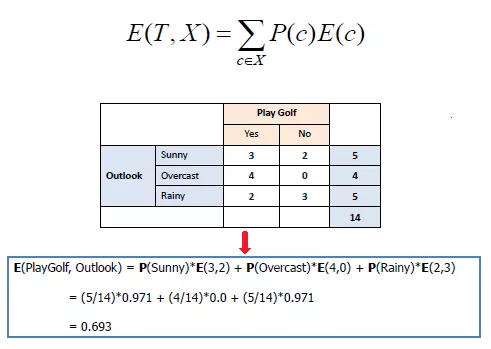

3).计算信息增益。
![image.png](3.png)

### 第一步，计算根结点的信息熵为，即y的

### 第二步，根据各个特征计算中每个特征的信息增益，选取增益最大的

### 第三步，在上一个特征选择基础上递归选择

![image.png](4.png)

In [2]:
import numpy as np
import pandas as pd
from math import log

df = pd.read_csv('./example_data.csv')
df

,humility,outlook,play,temp,windy
0,high,sunny,no,hot,False
1,high,sunny,no,hot,True
2,high,overcast,yes,hot,False
3,high,rainy,yes,mild,False
4,normal,rainy,yes,cool,False
5,normal,rainy,no,cool,True
6,normal,overcast,yes,cool,True
7,high,sunny,no,mild,False
8,normal,sunny,yes,cool,False
9,normal,rainy,yes,mild,False


In [3]:
def entropy(ele):    #定义熵的计算函数
    '''
    function: Calculating entropy value.
    input: A list contain categorical value.
    output: Entropy value.
    entropy = - sum(p * log(p)), p is a prob value.
    '''
    # Calculating the probability distribution of list value
    probs = [ele.count(i)/len(ele) for i in set(ele)]    
    # Calculating entropy value
    entropy = -sum([prob*log(prob, 2) for prob in probs])    
    return entropy

In [5]:
entropy(df['play'].tolist())

0.9402859586706309

In [6]:
def split_dataframe(data, col):    
    '''
    function: split pandas dataframe to sub-df based on data and column.
    input: dataframe, column name.
    output: a dict of splited dataframe.
    '''
    # unique value of column
    unique_values = data[col].unique()    #找到类别唯一值
    # empty dict of dataframe
    result_dict = {elem : pd.DataFrame for elem in unique_values}    
    # split dataframe based on column value
    for key in result_dict.keys():
        result_dict[key] = data[:][data[col] == key]    
    return result_dict

In [14]:
split_example = split_dataframe(df,'temp')
for subset_col, subset in (split_example).items():
    print(subset_col)
    print(subset)

hot
   humility   outlook play temp  windy
0      high     sunny   no  hot  False
1      high     sunny   no  hot   True
2      high  overcast  yes  hot  False
12   normal  overcast  yes  hot  False
mild
   humility   outlook play  temp  windy
3      high     rainy  yes  mild  False
7      high     sunny   no  mild  False
9    normal     rainy  yes  mild  False
10   normal     sunny  yes  mild   True
11     high  overcast  yes  mild   True
13     high     rainy   no  mild   True
cool
  humility   outlook play  temp  windy
4   normal     rainy  yes  cool  False
5   normal     rainy   no  cool   True
6   normal  overcast  yes  cool   True
8   normal     sunny  yes  cool  False


In [20]:
def choose_best_col(df, label):    #根据熵计算公式和数据集划分方法计算信息增益来选择最佳特征的过程：
    '''
    funtion: choose the best column based on infomation gain.
    input: datafram, label
    output: max infomation gain, best column, 
            splited dataframe dict based on best column.
    '''
    # Calculating label's entropy
    entropy_D = entropy(df[label].tolist())    
    # columns list except label
    cols = [col for col in df.columns if col not in [label]]    #找label之外的特征
    # initialize the max infomation gain, best column and best splited dict
    max_value, best_col = -999, None
    max_splited = None
    # split data based on different column
    for col in cols:
        splited_set = split_dataframe(df, col)
        entropy_DA = 0
        for subset_col, subset in splited_set.items():            
            # calculating splited dataframe label's entropy
            entropy_Di = entropy(subset[label].tolist())            
            # calculating entropy of current feature
            entropy_DA += len(subset)/len(df) * entropy_Di  #不同特征所占比例      
        # calculating infomation gain of current feature
        info_gain = entropy_D - entropy_DA        
        if info_gain > max_value: #更新最大的
            max_value, best_col = info_gain, col
            max_splited = splited_set    
        return max_value, best_col, max_splited

In [21]:
choose_best_col(df,'temp') #temp为y的话先选到特征humodity

(0.3746508927026091,
 'humility',
 {'high':    humility   outlook play  temp  windy
  0      high     sunny   no   hot  False
  1      high     sunny   no   hot   True
  2      high  overcast  yes   hot  False
  3      high     rainy  yes  mild  False
  7      high     sunny   no  mild  False
  11     high  overcast  yes  mild   True
  13     high     rainy   no  mild   True,
  'normal':    humility   outlook play  temp  windy
  4    normal     rainy  yes  cool  False
  5    normal     rainy   no  cool   True
  6    normal  overcast  yes  cool   True
  8    normal     sunny  yes  cool  False
  9    normal     rainy  yes  mild  False
  10   normal     sunny  yes  mild   True
  12   normal  overcast  yes   hot  False})

## ID3的不足
我们从上面求解信息增益的公式中，其实可以看出，信息增益准则其实是对**可取值数目较多的属性有所偏好！**
现在假如我们把数据集中的“编号”也作为一个候选划分属性。我们可以算出“编号”的信息增益是0.998
因为每一个样本的编号都是不同的（**由于编号独特唯一，条件熵为0了**，每一个结点中只有一类，纯度非常高啊），也就是说，来了一个预测样本，你只要告诉我编号，其它特征就没有用了，这样生成的决策树显然不具有泛化能力。


于是我们就引入了信息增益率来选择最优划分属性！

![image.png](5.png)
由上图我们可以看出，信息增益率=信息增益/IV(a),说明信息增益率是信息增益除了一个属性a的固有值得来的。

## C4.5

### 1、连续变离散
eg：从小到大排列：70，95，100，120，125
计算中值T：82.5，97.5，110，122.5

算T取不同值的信息增益，选最大的T

### 2、信息增益率
信息增益除以属性熵，即本身特征自己的信息熵，不带标签y的。、


**但是！** 使用增益率可能产生另外一个问题，就是如果属性取值数目较少，我们来想一个比较极端的例子，假如属性只取一个值，属性熵就是0。我们知道一个数除以一个接近0的数，会变成无穷大。所以增益率可能会**偏好取值比较少的属性**。因此C4.5采用了一个启发式的算法，**先从候选属性中找出高于平均水平的属性，再从高于平均水平的属性中选择增益率最高的属性。**

### 3、缺失值的处理
### 4、通过剪枝解决“过拟合”